In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import tensorflow as tf
np.random.seed(seed=0)

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [3]:
books_path = "./books-autoencoder/"
new_path = "../"
books_list = sorted(os.listdir(books_path))

documents = list()

for i in books_list:
    f = open(books_path + i, 'r')
    doc = list(map(lambda x: x.replace("\n", ""), f.readlines()))
    doc = [x.replace("</s>", "") for x in doc]
    documents.extend(doc)


    f.close()

In [4]:
documents[2]

'그 연줄이 잠긴 자새와 연을 내게 쥐주고 집을 나설 때 섭섭해 울라카는 나를 보고 아부지는 노상 이런 말씀을 하셨 능기라 아부지가 보고 싶으모 이 연을 훨훨 띠아라 저 하늘 높이게 연이 나르는 곳이 바로 아부지가 기시는 곳이거덩 하고 말이다 나는 엄동 석달만이 아니고 봄가실에도 연을 날리며 연맨쿠로 멀리멀 리 떠 댕기는 아부지를 그리며 컸어 연이 작은 새가 돼서 아주 멀리 멀리로 날아가모 나도 연이 돼서 그렇게 하늘 꼭대리고 떠돌아댕겼제 내가 니 나이만 했을 때 바람 쌩쌩한 어느 겨울이었어 내가 날린 연 과 마실 아이의 연이 쌈을 붙잖았능가베 연줄이 서로 섞갈리자 나는 자새로 실이 다 풀리도록 연을 멀리로 띄아보냈거덩 낯짝만 하던 연 이 손가락맨큼 작아지고 마지막에는 바둑돌맨큼 작아져서 가물거릴 때까지 연줄을 죄 풀어주었제 둘러선 마실 아이들이 하늘 저 멀리로 콩알만해 진 연 두 개를 조마조마하게 쳐다 보았어'

In [5]:
text_len = [len(s.split()) for s in documents]

In [6]:
np.min(text_len)

2

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 2406
텍스트의 평균 길이 : 76.20321720921378


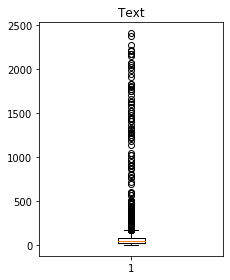

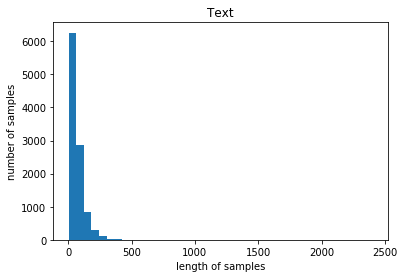

In [7]:
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
text_max_len = 300

In [9]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [10]:
below_threshold_len(text_max_len, documents)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 0.9872453835903293


In [11]:
encoder_input = [x for x in documents if len(x.split()) <= text_max_len]

In [12]:
decoder_input = ['sostoken ' + x for x in encoder_input ]
decoder_target = [x + ' eostoken' for x in encoder_input ]

In [13]:
encoder_input = np.array(encoder_input)
decoder_input = np.array(decoder_input)
decoder_target = np.array(decoder_target)

In [14]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[6157 3673 3583 ... 3264 9845 2732]


In [15]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 2074


In [16]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [17]:
print(len(encoder_input_train))
print(len(decoder_input_train))
print(len(decoder_target_train))

8298
8298
8298


In [18]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 8298
훈련 레이블의 개수 : 8298
테스트 데이터의 개수 : 2074
테스트 레이블의 개수 : 2074


In [19]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [20]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 125143
등장 빈도가 6번 이하인 희귀 단어의 수: 115248
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9895
단어 집합에서 희귀 단어의 비율: 92.09304555588406
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 32.68718233340721


In [21]:
src_vocab = 110000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [22]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [23]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 125144
등장 빈도가 5번 이하인 희귀 단어의 수: 113493
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11651
단어 집합에서 희귀 단어의 비율: 90.6899252061625
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 30.258372293070153


In [24]:
tar_vocab = 110000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [25]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [26]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [27]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [28]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 8298
훈련 레이블의 개수 : 8298
테스트 데이터의 개수 : 2074
테스트 레이블의 개수 : 2074


/home/tako/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [29]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = text_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = text_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = text_max_len, padding='post')

In [30]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
embedding_dim = 128
hidden_size = 256

In [33]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [32]:
def encoder(hidden_size, text_max_len, src_vocab, embedding_dim, name='encoder'):
    
    encoder_inputs = Input(shape=(text_max_len, ))

    # 인코더의 임베딩 층
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
    
    return Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c], name=name)

In [37]:
def decoder(tar_vocab, embedding_dim, hidden_size, name='decoder'):

    encoder_outputs = Input(shape=(None, embedding_dim))
    decoder_inputs = Input(shape=(None,))
    state_h = Input(shape=(None, embedding_dim))
    state_c = Input(shape=(None, embedding_dim))
    
    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])
    
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

    return Model(inputs = [encoder_outputs, state_h, state_c, decoder_inputs], outputs = decoder_softmax_outputs)

In [41]:
def autoencoder(hidden_size, text_max_len, src_vocab, tar_vocab, embedding_dim, name='autoencoder'):
    encoder_inputs = Input(shape=(text_max_len, ))
    decoder_inputs = Input(shape=(None,))

    # 인코더의 임베딩 층
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
    
    #return Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c], name=name)
        
    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])
    
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

    #return Model(inputs = [encoder_outputs, state_h, state_c, decoder_inputs], outputs = decoder_softmax_outputs)
    
    return Model([encoder_inputs, decoder_inputs], outputs = decoder_softmax_outputs)

In [42]:
model = autoencoder(hidden_size, text_max_len, src_vocab, tar_vocab, embedding_dim, name='autoencoder')

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 4, callbacks=[es], epochs = 50)

Train on 8298 samples, validate on 2074 samples
Epoch 1/50
  24/8298 [..............................] - ETA: 1:25:06 - loss: 10.0857WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("예측 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


In [ ]:
model.save("novel_model1.h5")

In [ ]:
from keras.models import load_model
from attention import AttentionLayer
model = load_model("novel_model1.h5", custom_objects={'AttentionLayer':AttentionLayer})

In [ ]:
model.summary()